<a href="https://colab.research.google.com/github/demelere/Weld-Seam-Finding/blob/main/FastSAM_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [1]:
!git clone https://github.com/demelere/FastSAM.git

Cloning into 'FastSAM'...
remote: Enumerating objects: 1349, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 1349 (delta 359), reused 323 (delta 316), pack-reused 928 (from 1)
Receiving objects: 100% (1349/1349), 72.57 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (555/555), done.


In [2]:
!nvidia-smi

Wed Apr 16 00:18:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!wget https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt

--2025-04-16 00:18:57--  https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.118, 18.164.174.23, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/71/c3/71c3ec5a83f3fc374665cec9240f614262e29088fca1a18732571e13c7084f1b/c0be4e7ddbe4c15333d15a859c676d053c486d0a746a3be6a7a9790d52a9b6d7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27FastSAM.pt%3B+filename%3D%22FastSAM.pt%22%3B&Expires=1744766337&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NDc2NjMzN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy83MS9jMy83MWMzZWM1YTgzZjNmYzM3NDY2NWNlYzkyNDBmNjE0MjYyZTI5MDg4ZmNhMWExODczMjU3MWUxM2M3MDg0ZjFiL2MwYmU0ZTdkZGJlNGMxNTMzM2QxNWE4NTljNjc2ZDA1M2M0ODZkMGE3NDZhM2JlNmE3YTk3OTBkNTJhOWI2ZDc%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3Npd

In [4]:
!pip install -r FastSAM/requirements.txt
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement torchvision<0.14,>=0.8.1 (from versions: 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0)
ERROR: No matching distribution found for torchvision<0.14,>=0.8.1
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1x2lgtfe
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1x2lgtfe
  Resolved https://github.com/openai/CLIP.git to 

## Load and preview input image

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from google.colab import files

# or can wget a sample image; not many suitable pre-weld/fit up joints images available through google search though
uploaded = files.upload()

In [6]:
print(os.listdir())

['.config', 'FastSAM.pt', 'tee-joint.jpg', 'FastSAM', 'sample_data']


In [8]:
os.makedirs('./output', exist_ok=True)

In [9]:
image_path = './tee-joint.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

608 696


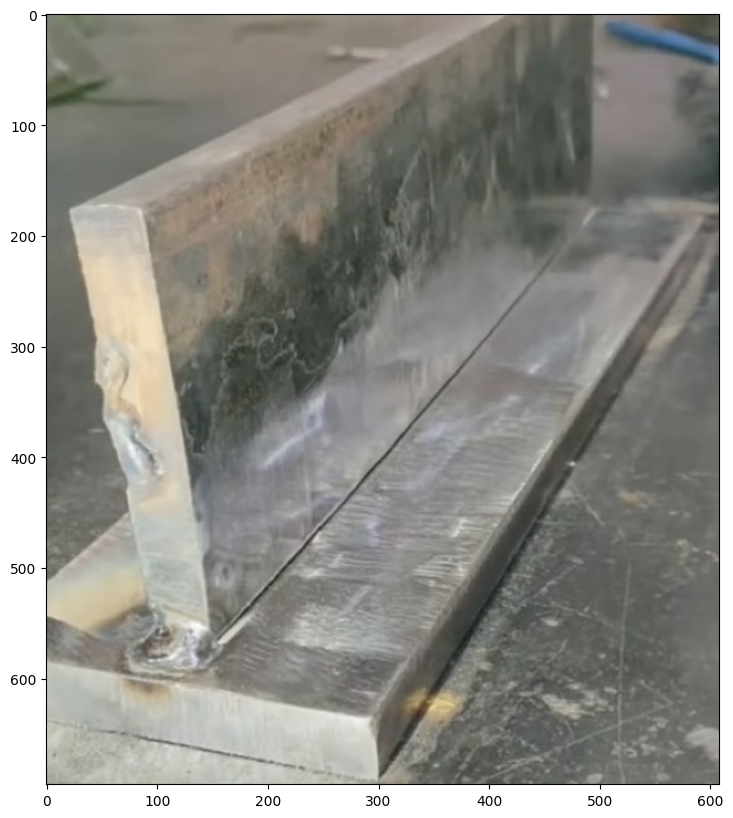

In [10]:
original_h = image.shape[0]
original_w = image.shape[1]
print(original_w, original_h)
plt.figure(figsize=(10, 10))
plt.imshow(image)

"--imgsz 1024" means the input image size is 1024. Our model was trained on a size of 1024. You can change it to any size you want to input. Using other sizes would produce different segmentation results.

## Run segmentation inference

In [11]:
!python FastSAM/Inference.py --model_path FastSAM.pt --img_path ./tee-joint.jpg --imgsz 1024

2025-04-16 00:21:51.479340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744762911.727490    1046 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744762911.790117    1046 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

0: 1024x896 7 objects, 154.0ms
Speed: 16.8ms preprocess, 154.0ms inference, 462.0ms postprocess per image at shape (1, 3, 1024, 1024)


## Load and visualize segmentation inference

608 696


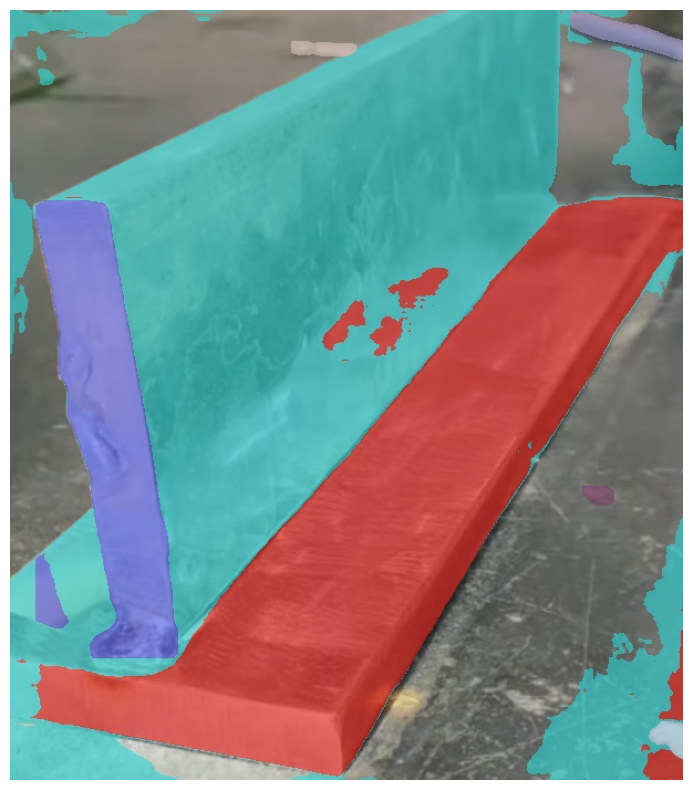

In [12]:
output_path = './output/tee-joint.jpg'
result_image = cv2.imread(output_path)
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
original_h = result_image.shape[0]
original_w = result_image.shape[1]
print(original_w, original_h)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(result_image)

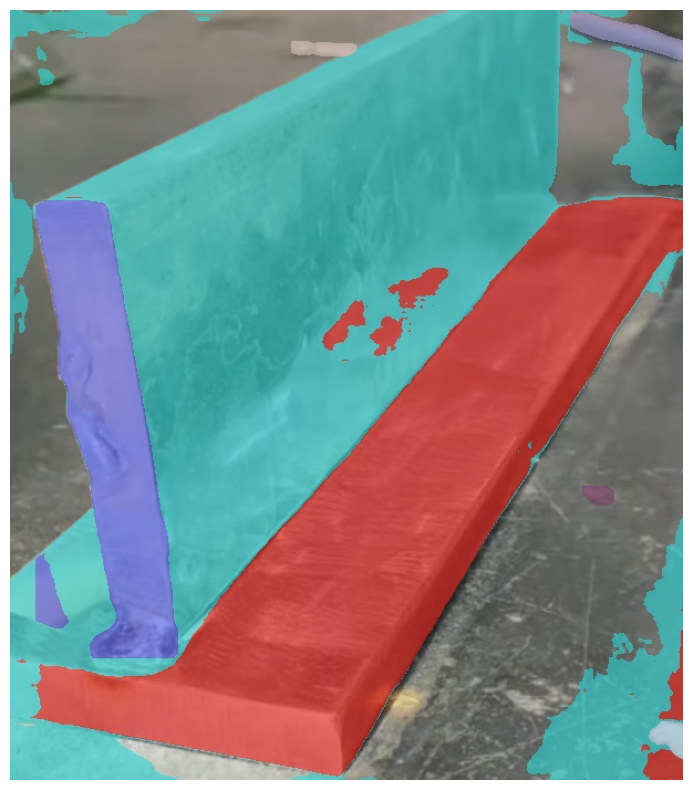

In [19]:
output_path = './output/tee-joint.jpg'
seg_img = cv2.imread(output_path)
seg_img_rgb = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(seg_img_rgb)
plt.axis('off')
plt.show()

## Extract segmentation masks

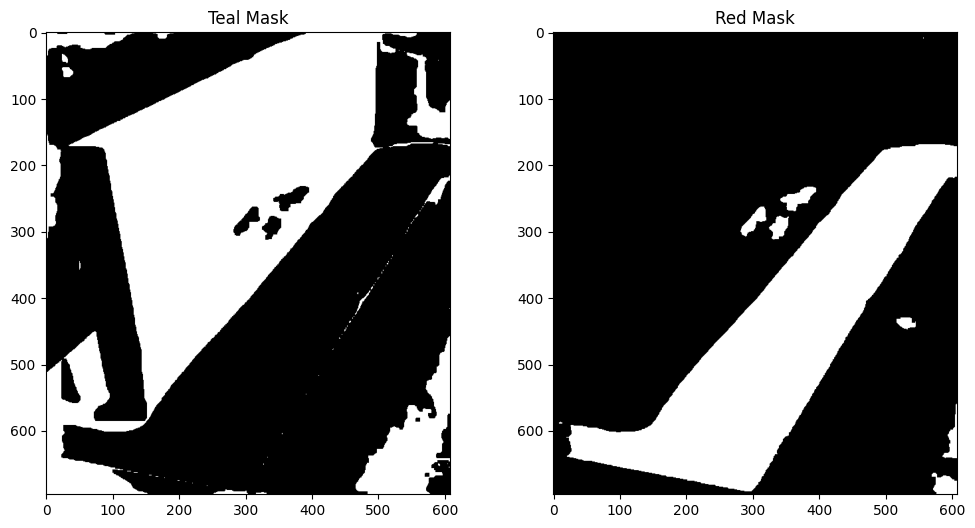

In [20]:
hsv = cv2.cvtColor(seg_img, cv2.COLOR_BGR2HSV) # convert to HSV for better color segmentation

teal_lower = np.array([80, 50, 50]) # define color ranges to differentiate teal and red masks
teal_upper = np.array([100, 255, 255])
red_lower1 = np.array([0, 50, 50])
red_upper1 = np.array([10, 255, 255])
red_lower2 = np.array([160, 50, 50])
red_upper2 = np.array([180, 255, 255])

teal_mask = cv2.inRange(hsv, teal_lower, teal_upper)
red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
red_mask = cv2.bitwise_or(red_mask1, red_mask2)

kernel = np.ones((5,5), np.uint8)
teal_mask = cv2.morphologyEx(teal_mask, cv2.MORPH_CLOSE, kernel)
red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Teal Mask')
plt.imshow(teal_mask, cmap='gray')
plt.subplot(1,2,2)
plt.title('Red Mask')
plt.imshow(red_mask, cmap='gray')
plt.show()

## Find seam centerline and extract boundary

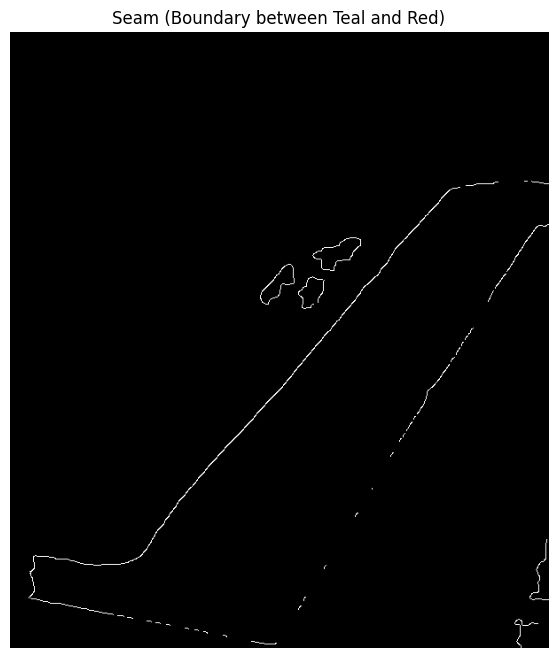

In [21]:
teal_edges = cv2.Canny(teal_mask, 100, 200) # find the edges of each mask
red_edges = cv2.Canny(red_mask, 100, 200)

# the seam is where the edges are close to each other.  dilate one edge and find overlap with the other
dilated_teal = cv2.dilate(teal_edges, np.ones((3,3), np.uint8), iterations=1)
seam = cv2.bitwise_and(dilated_teal, red_edges)

plt.figure(figsize=(8,8))
plt.title('Seam (Boundary between Teal and Red)')
plt.imshow(seam, cmap='gray')
plt.axis('off')
plt.show()

Number of seam points: 1999


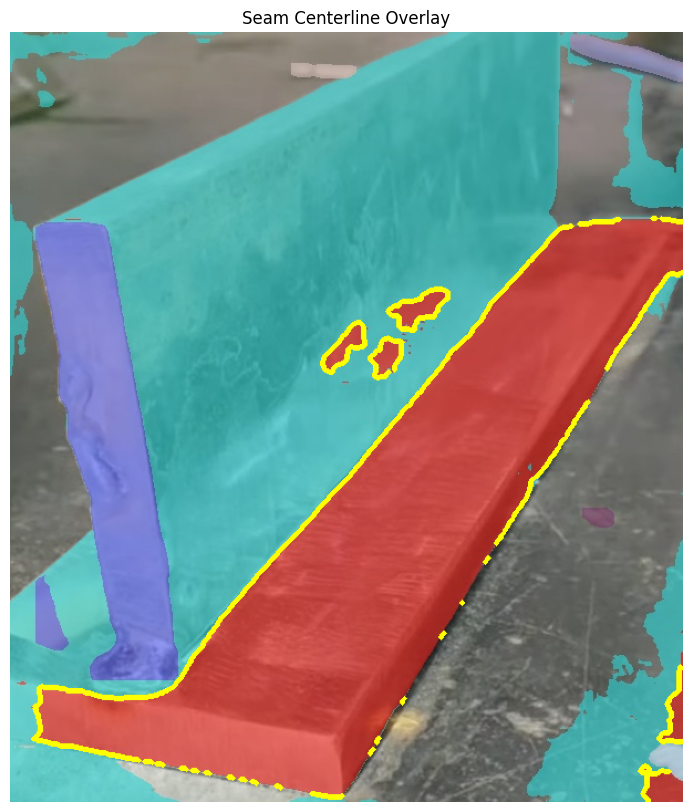

In [23]:
ys, xs = np.where(seam > 0) # get seam coordinates
seam_coords = np.column_stack((xs, ys))

print("Number of seam points:", len(seam_coords))
seam_vis = seg_img_rgb.copy()
for (x, y) in seam_coords:
    seam_vis[y, x] = [255, 255, 0]  # yellow
    cv2.circle(seam_vis, (x, y), radius=2, color=(255, 255, 0), thickness=-1)  # make more visible

plt.figure(figsize=(10,10))
plt.title('Seam Centerline Overlay')
plt.imshow(seam_vis)
plt.axis('off')
plt.show()

## Fit and visualize a smooth spline centerline

Produces a smooth, continuous path—ideal for robot motion.  Can interpolate through all seam points (if desired).  Good for relatively clean, low-noise data.  However, it's sensitive to noise and outliers and can overfit if the seam is jagged and has sharp corners.  It needs the points to be reordered along the seam.

Alternatives
*   RANSAC might be most robust, should try that one.
*   Split and merge / piecewise fitting seems like a balance between spline fitting and RANSAC


In [1]:
# to do: if the seam is mostly horizontal, sort by x; if vertical, sort by y.  in this case, sorting by x
seam_coords_sorted = seam_coords[seam_coords[:,0].argsort()]
xs = seam_coords_sorted[:,0]
ys = seam_coords_sorted[:,1]

NameError: name 'seam_coords' is not defined

In [25]:
from scipy.interpolate import UnivariateSpline
import numpy as np

# to do:
spline = UnivariateSpline(xs, ys, s=50)  # fit a spline (adjust s for smoothness; higher s = smoother)

x_smooth = np.linspace(xs.min(), xs.max(), 500) # generate the smoothed values
y_smooth = spline(x_smooth)

In [26]:
seam_vis = seg_img_rgb.copy()
# Draw the spline as a thick yellow line
for (x, y) in zip(x_smooth.astype(int), y_smooth.astype(int)):
    cv2.circle(seam_vis, (x, y), radius=2, color=(255, 255, 0), thickness=-1)

plt.figure(figsize=(10,10))
plt.title('Spline-Fitted Seam Centerline')
plt.imshow(seam_vis)
plt.axis('off')
plt.show()

<ipython-input-26-4bb37a9d44b4>:3: RuntimeWarning: invalid value encountered in cast
  for (x, y) in zip(x_smooth.astype(int), y_smooth.astype(int)):


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 1 has a wrong type
>  - Can't parse 'center'. Sequence item with index 1 has a wrong type
